## XS benchmark

Firts, import `sandy` and python packages

In [1]:
import sandy

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style("whitegrid")

In [3]:
%load_ext autoreload
%autoreload 2

**Problem description**: Create 100 samples for $^{56}Fe$ from the tested library JEFF-3.3 and test the correct functioning of the `sandy` sampling. 

Creation of the samples:

In [4]:
NSMP = 100
mat = 2631
endf6 = sandy.get_endf6_file('jeff_33','xs', 260560)
endf6.to_file('Fe-56.dat')
out = sandy.sampling(f"Fe-56.dat --samples {NSMP} --mf 33 --outname Fe-56out --outdir Fe --debug --errorr".split())

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
If you want to process 0K cross sections use `temperature=0.1`.



MF[31,33] eigenvalues:
   EVAL    SAMPLES    DIFF %  
 6.94E+00  7.16E+00    -3.2   
 5.14E+00  5.24E+00    -2.0   
 4.59E+00  5.06E+00   -10.3   
 4.46E+00  3.74E+00    16.2   
 2.82E+00  3.33E+00   -17.9   
 2.09E+00  2.14E+00    -2.5   
 1.77E+00  1.99E+00   -12.3   
 1.61E+00  1.73E+00    -7.6   
 1.44E+00  1.49E+00    -3.4   
 1.39E+00  1.29E+00    7.2    


INFO:  Running on Windows does not allow parallel processing


Created sample 1 for MAT 2631 in 11.14 sec
Created sample 2 for MAT 2631 in 8.66 sec
Created sample 3 for MAT 2631 in 8.48 sec
Created sample 4 for MAT 2631 in 7.93 sec
Created sample 5 for MAT 2631 in 8.45 sec
Created sample 6 for MAT 2631 in 8.58 sec
Created sample 7 for MAT 2631 in 8.01 sec
Created sample 8 for MAT 2631 in 7.89 sec
Created sample 9 for MAT 2631 in 8.16 sec
Created sample 10 for MAT 2631 in 8.23 sec
Created sample 11 for MAT 2631 in 7.93 sec
Created sample 12 for MAT 2631 in 8.77 sec
Created sample 13 for MAT 2631 in 8.83 sec
Created sample 14 for MAT 2631 in 7.94 sec
Created sample 15 for MAT 2631 in 8.31 sec
Created sample 16 for MAT 2631 in 15.24 sec
Created sample 17 for MAT 2631 in 13.21 sec
Created sample 18 for MAT 2631 in 13.22 sec
Created sample 19 for MAT 2631 in 8.02 sec
Created sample 20 for MAT 2631 in 7.93 sec
Created sample 21 for MAT 2631 in 7.92 sec
Created sample 22 for MAT 2631 in 8.53 sec
Created sample 23 for MAT 2631 in 11.93 sec
Created sample 

Obtention of the XS for $^{56}Fe$ processed with `NJOY`:

XS object (PENDF) and ERRORR data:

In [5]:
xs_original_processed = sandy.Xs.from_file('26056.pendf')
xs_errorr = sandy.Errorr.from_file('26056.0.errorr')
cov_original = xs_errorr.get_cov()

XS object(12 groups):

In [6]:
energy_grid = sandy.energy_grids.CASMO12
xs_errorr_groups = endf6.get_errorr(ek=energy_grid)

Information from the samples:

In [7]:
def samples_info(mat, NSMP, **kwargs):
    xss_groups = []
    ek = kwargs.get('ek', None)
    mt = kwargs.get('MT', range(1, 10000))
    for i in range(1, NSMP+1):
        e6 = sandy.Endf6.from_text(out[2][mat][i])
        try:
            xs_groupr = e6.get_gendf() if ek is None else e6.get_gendf(ek=ek)
            xs_groupr = xs_groupr.get_xs(mt=mt).data.squeeze()
            xs_groupr = pd.concat([xs_groupr], keys=[i], names=['SMP'], axis=1)
            xss_groups.append(xs_groupr)
        except IndexError:
            continue
    df_groups = pd.concat(xss_groups, axis=1).T
    df_groups.index.name = "E"
    stack_groups = df_groups.stack().rename("XS").reset_index()
    return stack_groups, df_groups

def best_estimate_vs_samples_mean(df_groups):
    distribution = df_groups.stack().rename("XS").reset_index()
    distribution['E'] = pd.Index(distribution['E']).left.values
    dat = []
    for SMP in range(1, NSMP+1):
        mean_per_sample = distribution.query("SMP <= "+str(SMP)).groupby('E')['XS'].mean().rename(str(SMP))
        dat.append(mean_per_sample)
    mean_sample = pd.concat(dat, axis=1).stack().rename('mean per sample').reset_index().rename(columns={'level_1':'SMP'})
    Xs_calc = distribution.groupby('E')['XS'].mean().reindex(mean_sample['E'])
    mean_sample = mean_sample.set_index('E')
    mean_sample['sample mean'] = mean_sample['mean per sample']/Xs_calc
    mean_sample = mean_sample.reset_index()
    mean_sample = mean_sample.astype({'SMP': int})
    return mean_sample

def std_vs_samples_mean(df_groups):
    distribution = df_groups.stack().rename("XS").reset_index()
    distribution['E'] = pd.Index(distribution['E']).left.values
    dat = []
    for SMP in range(1, NSMP+1):
        std_per_sample = distribution.query("SMP <= "+str(SMP)).groupby('E')['XS'].std().rename(str(SMP))
        dat.append(std_per_sample)
    std_sample = pd.concat(dat, axis=1).stack().rename('std per sample').reset_index().rename(columns={'level_1':'SMP'})
    Xs_calc = distribution.groupby('E')['XS'].std().reindex(std_sample['E'])
    std_sample = std_sample.set_index('E')
    std_sample['sample std'] = std_sample['std per sample']/Xs_calc
    std_sample = std_sample.reset_index()
    std_sample = std_sample.astype({'SMP': int})
    return std_sample

In [8]:
stack_groups, df_groups = samples_info(mat, NSMP, MT=[2, 102, 4])

In [9]:
stack_groups_small, df_groups_small = samples_info(mat, NSMP, ek=energy_grid, MT=[2, 102, 4])

## Elastic scattering xs analysis:

Comparison: PENDF xs vs sample multigroup mean

In [10]:
mt = 2
# Proccessed xs:
stack_o = xs_errorr.get_xs(mat=mat, mt=mt).data.squeeze()
stack_o = pd.Series(stack_o.values, index=stack_o.index.left)
stack_o = stack_o.rename('XS process').to_frame()

# Multigroup data:
multigroup_samples = stack_groups.query(f"MT == {mt}").set_index('E')
multigroup_samples.index = multigroup_samples.index.left
multigroup_samples = multigroup_samples.reset_index().rename(columns={'index':'E'})

# Calculations:
xs_calc = stack_groups.query(f"MT == {mt}").groupby('E')['XS'].mean()
stack_o['XS mean samples'] =  xs_calc.values
stack_o['relative diff'] = (1 - stack_o['XS mean samples'] / stack_o['XS process']) * 100
stack_o = stack_o.reset_index().rename(columns={'index': 'E'})

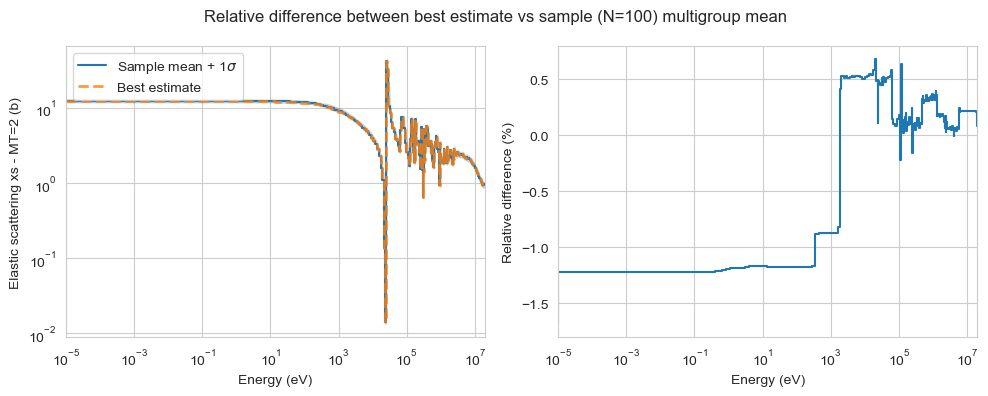

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

ax = axs[0]
sns.lineplot(data=multigroup_samples, x='E', y="XS", ci="sd", ax=ax, label='Sample mean + 1$\\sigma$', drawstyle='steps-pre')
stack_o.plot(x='E', y='XS process', ax=ax, alpha=0.8, style="--", linewidth=2, label="Best estimate", drawstyle='steps-pre')
ax.set_xlim([1e-5, 2e7])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(f'Elastic scattering xs - MT={mt} (b)')
ax.set_xlabel('Energy (eV)')

ax = axs[1]
sns.lineplot(data=stack_o, x='E', y='relative diff', ax=ax, drawstyle='steps-pre')
ax.set_xscale('log')
ax.set_ylabel('Relative difference (%)')
ax.set_xlim([1e-5, 2e7])
ax.set_xlabel('Energy (eV)')
fig.suptitle(f'Relative difference between best estimate vs sample (N={NSMP}) multigroup mean')

fig.tight_layout()

Visual comparison of the correlation matrix: sample multigroup vs Errorr file

In [12]:
cov = sandy.CategoryCov(cov_original.data.loc[(mat, mt), (mat, mt)])
cov_samples = sandy.EnergyCov(df_groups.query(f"MT == {mt}").cov()).data
cov_samples.index, cov_samples.columns = cov_samples.index.left, cov_samples.columns.left
cov_samples = sandy.EnergyCov(cov_samples)

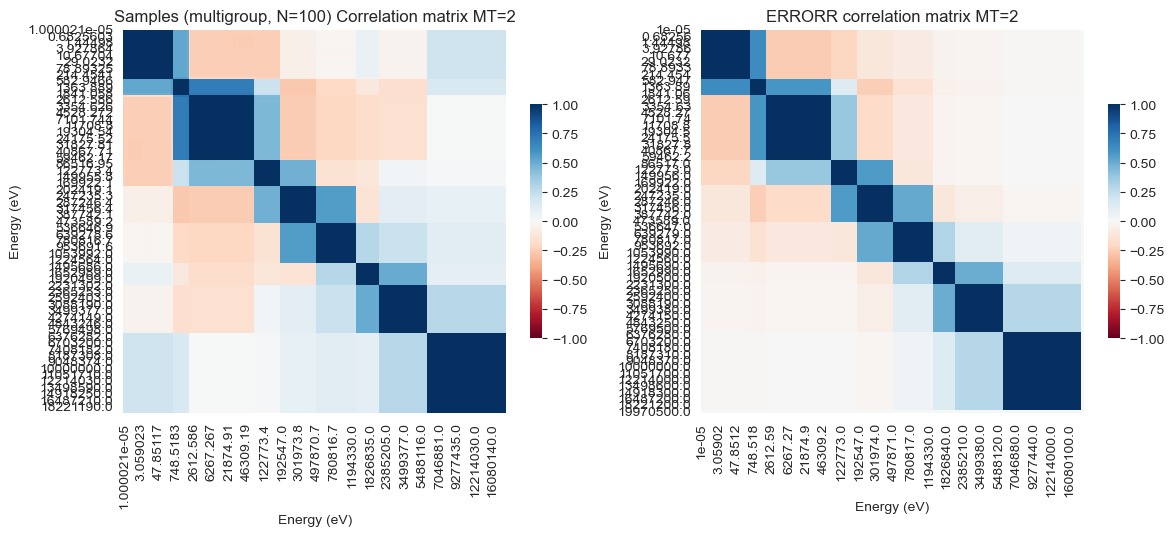

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 12), dpi=100)
ax1, ax2 = axes

# Formatting for heat map 1.
ax1.set_aspect("equal")
cov_samples.plot_corr(ax=ax1, cbar_kws={"shrink": .2})
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Energy (eV)')
ax1.set_title(f'Samples (multigroup, N={NSMP}) Correlation matrix MT={mt}')

ax2.set_aspect("equal")
cov.plot_corr(ax=ax2, cbar_kws={"shrink": .2})
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Energy (eV)')
ax2.set_title(f'ERRORR correlation matrix MT={mt}')

fig.tight_layout()

Standard deviation:

In [14]:
df_samples = df_groups.query(f"MT == {mt}").T.std(axis=1)/df_groups.query(f"MT == {mt}").T.mean(axis=1)*100
df_samples = pd.Series(df_samples.values, index=df_samples.index.left)
df_process = cov.std*100
df_std = (1-df_samples/df_process.drop(df_process.index[-1]).values)*100

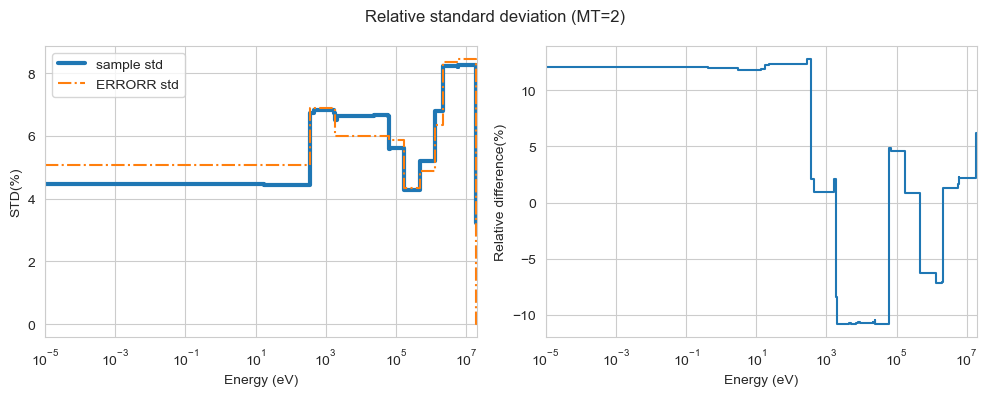

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

ax = axs[0]
df_samples.plot(logx=True, drawstyle='steps-pre', ax=ax, linewidth=3, label='sample std')
df_process.plot(logx=True, drawstyle='steps-pre', ax=ax, style="-.", label='ERRORR std')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('STD(%)')
ax.set_xlim([1e-5, 2e7])
ax.legend(loc='upper left')

ax = axs[1]
df_std.plot(logx=True, drawstyle='steps-pre', ax=ax)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Relative difference(%)')
ax.set_xlim([1e-5, 2e7])

fig.suptitle(f'Relative standard deviation (MT={mt})')
fig.tight_layout()

Samples distribution:

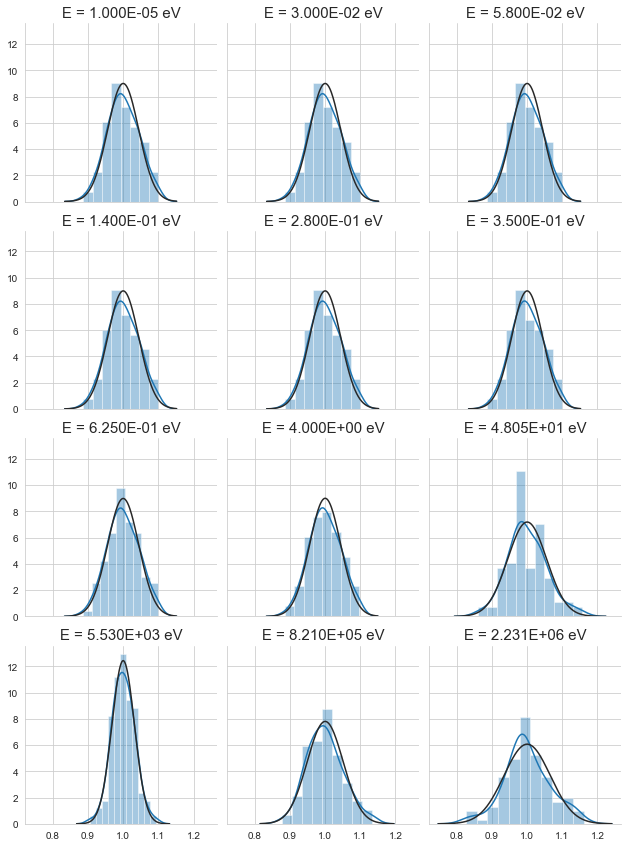

In [17]:
distribution = df_groups_small.query(f"MT == {mt}").stack().rename("XS").reset_index()
distribution['E'] = pd.Index(distribution['E']).left.values
Xs_calc = distribution.groupby('E')['XS'].mean().reindex(distribution['E'])
distribution = distribution.set_index('E')
distribution['Distribution'] = distribution['XS']/Xs_calc
distribution = distribution.reset_index()
g = sns.FacetGrid(distribution, col="E", col_wrap=3, height=3)
g.map(sns.distplot, "Distribution", fit=norm)
g.set_titles(col_template="E = {col_name:.3E} eV", fontsize=18, size=15) 
g.set_xlabels("")
g.set_ylabels("")

Best estimates of samples vs number of samples

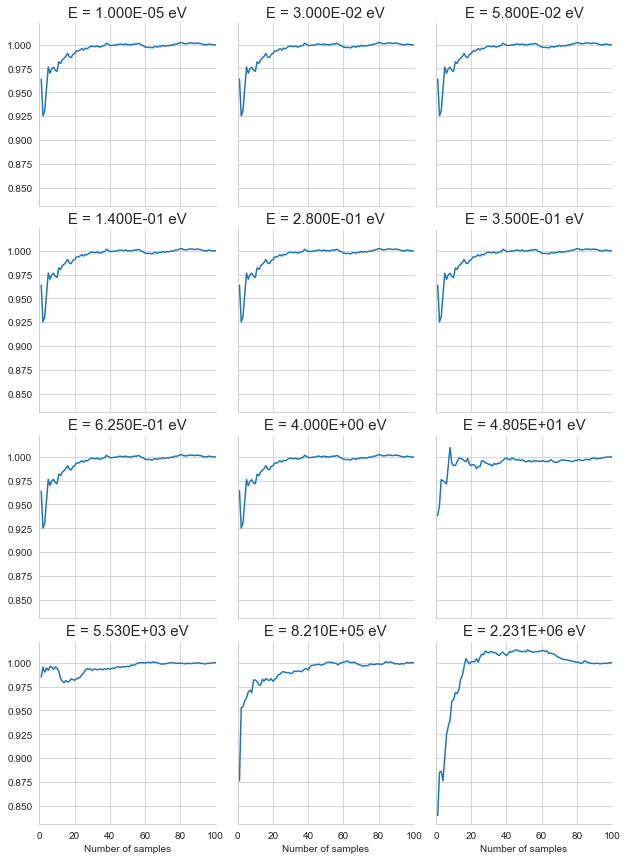

In [18]:
mean_sample = best_estimate_vs_samples_mean(df_groups_small.query(f"MT == {mt}"))
g = sns.FacetGrid(mean_sample, col="E", col_wrap=3, height=3, xlim=(0, NSMP))
g.map(sns.lineplot, "SMP", "sample mean")
g.set_titles(col_template="E = {col_name:.3E} eV", fontsize=18, size=15) 
g.set_xlabels("Number of samples")
g.set_ylabels("")

Standard deviation of samples vs number of samples

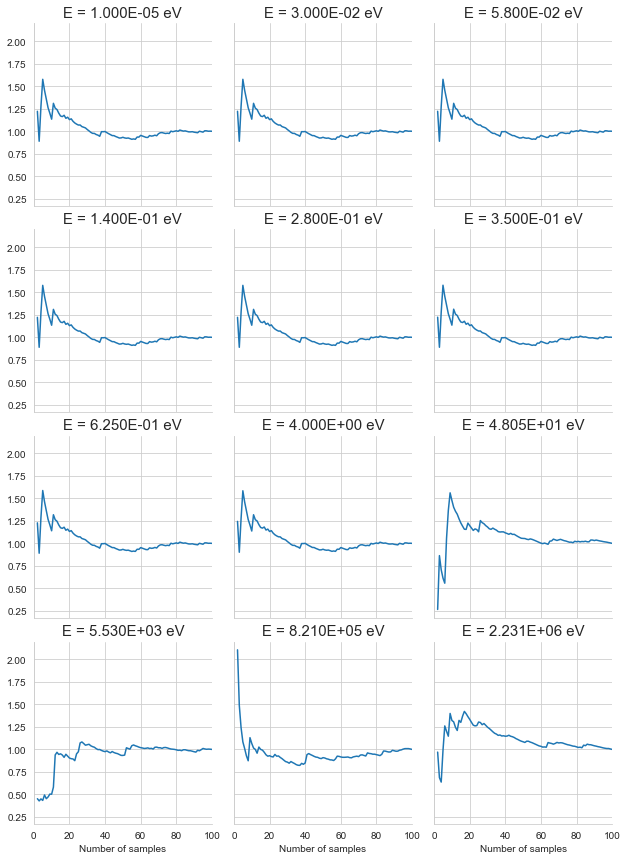

In [19]:
std_sample = std_vs_samples_mean(df_groups_small.query(f"MT == {mt}"))
g = sns.FacetGrid(std_sample, col="E", col_wrap=3, height=3, xlim=(0, NSMP))
g.map(sns.lineplot, "SMP", "sample std")
g.set_titles(col_template="E = {col_name:.3E} eV", fontsize=18, size=15) 
g.set_xlabels("Number of samples")
g.set_ylabels("")

## Capture xs analysis:

Comparison: PENDF xs vs sample multigroup mean

In [30]:
mt = 102
# Proccessed xs:
stack_o = xs_errorr.get_xs(mat=mat, mt=mt).data.squeeze()
stack_o = pd.Series(stack_o.values, index=stack_o.index.left)
stack_o = stack_o.rename('XS process').to_frame()

# Multigroup data:
multigroup_samples = stack_groups.query(f"MT == {mt}").set_index('E')
multigroup_samples.index = multigroup_samples.index.left
multigroup_samples = multigroup_samples.reset_index().rename(columns={'index':'E'})

# Calculations:
xs_calc = stack_groups.query(f"MT == {mt}").groupby('E')['XS'].mean()
stack_o['XS mean samples'] =  xs_calc.values
stack_o['relative diff'] = (1 - stack_o['XS mean samples'] / stack_o['XS process']) * 100
stack_o = stack_o.reset_index().rename(columns={'index': 'E'})

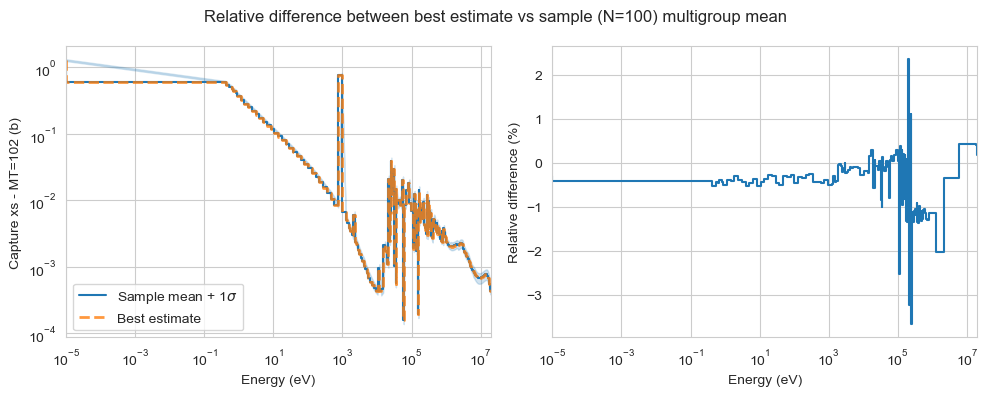

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

ax = axs[0]
sns.lineplot(data=multigroup_samples, x='E', y="XS", ci="sd", ax=ax, label='Sample mean + 1$\\sigma$', drawstyle='steps-pre')
stack_o.plot(x='E', y='XS process', ax=ax, alpha=0.8, style="--", linewidth=2, label="Best estimate", drawstyle='steps-pre')
ax.set_xlim([1e-5, 2e7])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(f'Capture xs - MT={mt} (b)')
ax.set_xlabel('Energy (eV)')

ax = axs[1]
sns.lineplot(data=stack_o, x='E', y='relative diff', ax=ax, drawstyle='steps-pre')
ax.set_xscale('log')
ax.set_ylabel('Relative difference (%)')
ax.set_xlim([1e-5, 2e7])
ax.set_xlabel('Energy (eV)')
fig.suptitle(f'Relative difference between best estimate vs sample (N={NSMP}) multigroup mean')

fig.tight_layout()

Visual comparison of the correlation matrix: sample multigroup vs Errorr file

In [32]:
cov = sandy.CategoryCov(cov_original.data.loc[(mat, mt), (mat, mt)])
cov_samples = sandy.EnergyCov(df_groups.query(f"MT == {mt}").cov()).data
cov_samples.index, cov_samples.columns = cov_samples.index.left, cov_samples.columns.left
cov_samples = sandy.EnergyCov(cov_samples)

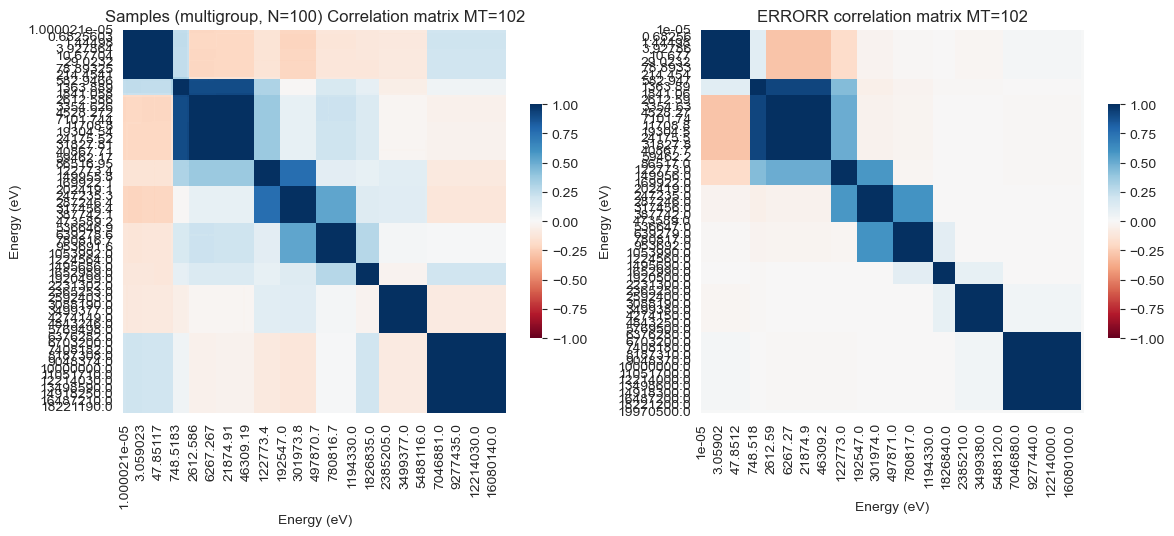

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 12), dpi=100)
ax1, ax2 = axes

# Formatting for heat map 1.
ax1.set_aspect("equal")
cov_samples.plot_corr(ax=ax1, cbar_kws={"shrink": .2})
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Energy (eV)')
ax1.set_title(f'Samples (multigroup, N={NSMP}) Correlation matrix MT={mt}')

ax2.set_aspect("equal")
cov.plot_corr(ax=ax2, cbar_kws={"shrink": .2})
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Energy (eV)')
ax2.set_title(f'ERRORR correlation matrix MT={mt}')

fig.tight_layout()

Standard deviation:

In [34]:
df_samples = df_groups.query(f"MT == {mt}").T.std(axis=1)/df_groups.query(f"MT == {mt}").T.mean(axis=1)*100
df_samples = pd.Series(df_samples.values, index=df_samples.index.left)
df_process = cov.std*100
df_std = (1-df_samples/df_process.drop(df_process.index[-1]).values)*100

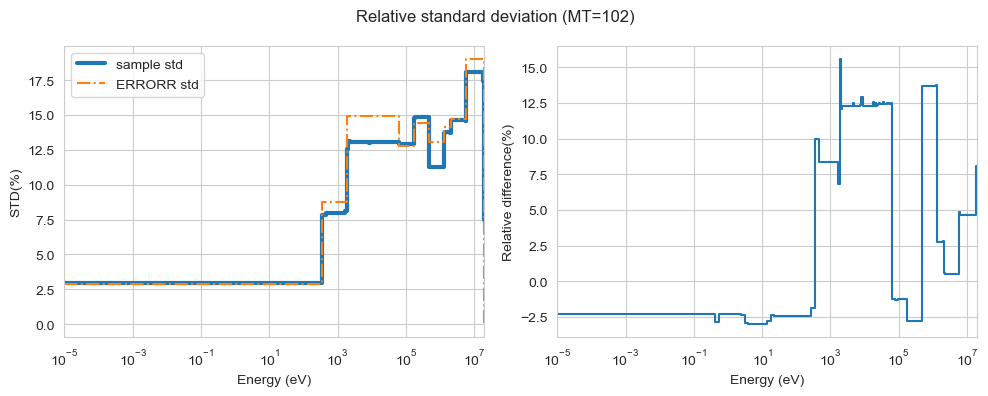

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

ax = axs[0]
df_samples.plot(logx=True, drawstyle='steps-pre', ax=ax, linewidth=3, label='sample std')
df_process.plot(logx=True, drawstyle='steps-pre', ax=ax, style="-.", label='ERRORR std')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('STD(%)')
ax.set_xlim([1e-5, 2e7])
ax.legend(loc='upper left')

ax = axs[1]
df_std.plot(logx=True, drawstyle='steps-pre', ax=ax)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Relative difference(%)')
ax.set_xlim([1e-5, 2e7])

fig.suptitle(f'Relative standard deviation (MT={mt})')
fig.tight_layout()

Samples distribution:

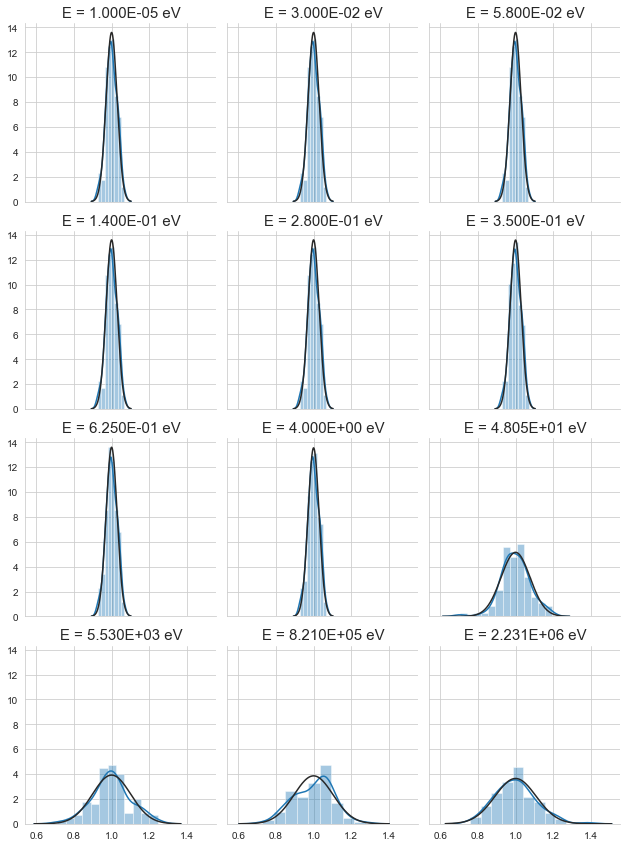

In [37]:
distribution = df_groups_small.query(f"MT == {mt}").stack().rename("XS").reset_index()
distribution['E'] = pd.Index(distribution['E']).left.values
Xs_calc = distribution.groupby('E')['XS'].mean().reindex(distribution['E'])
distribution = distribution.set_index('E')
distribution['Distribution'] = distribution['XS']/Xs_calc
distribution = distribution.reset_index()
g = sns.FacetGrid(distribution, col="E", col_wrap=3, height=3)
g.map(sns.distplot, "Distribution", fit=norm)
g.set_titles(col_template="E = {col_name:.3E} eV", fontsize=18, size=15) 
g.set_xlabels("")
g.set_ylabels("")

Best estimates of samples vs number of samples

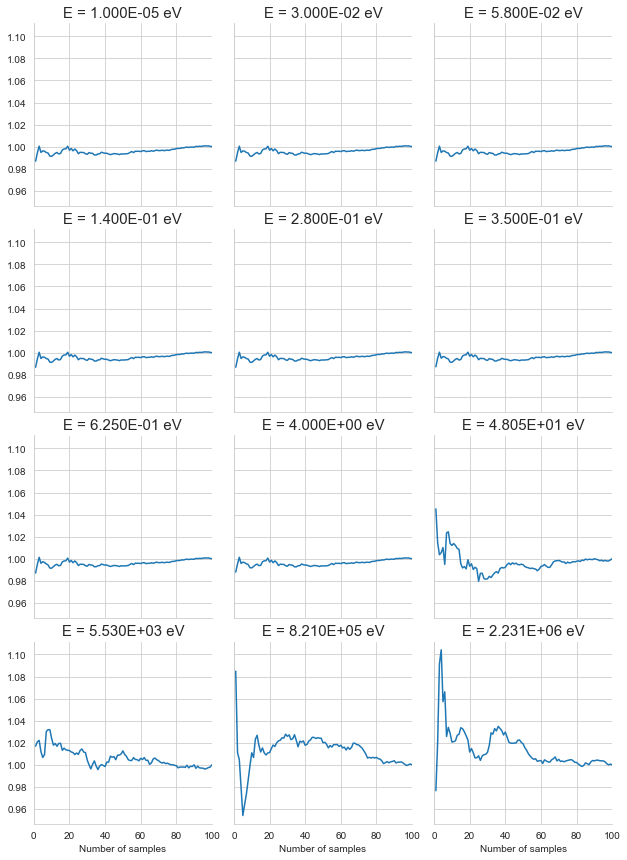

In [38]:
mean_sample = best_estimate_vs_samples_mean(df_groups_small.query(f"MT == {mt}"))
g = sns.FacetGrid(mean_sample, col="E", col_wrap=3, height=3, xlim=(0, NSMP))
g.map(sns.lineplot, "SMP", "sample mean")
g.set_titles(col_template="E = {col_name:.3E} eV", fontsize=18, size=15) 
g.set_xlabels("Number of samples")
g.set_ylabels("")

Standard deviation of samples vs number of samples

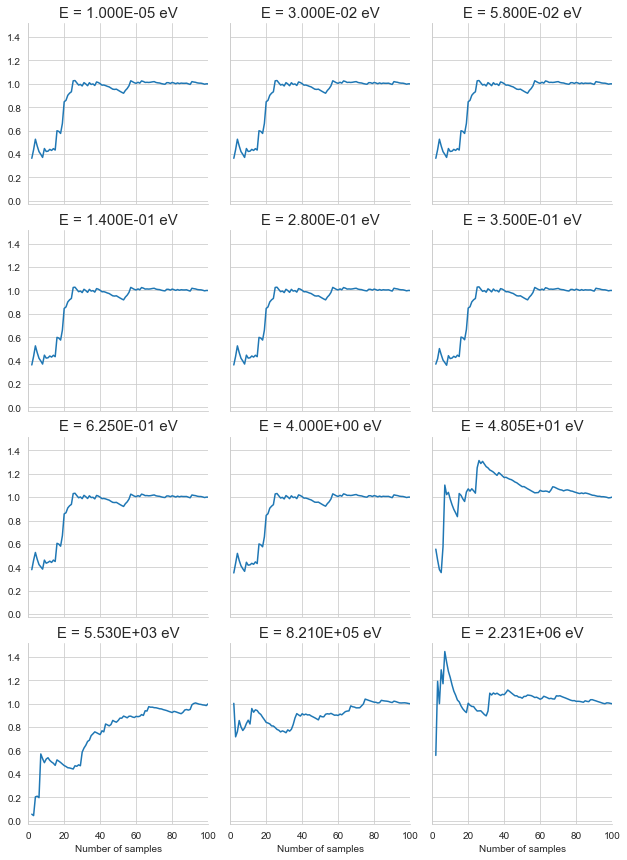

In [39]:
std_sample = std_vs_samples_mean(df_groups_small.query(f"MT == {mt}"))
g = sns.FacetGrid(std_sample, col="E", col_wrap=3, height=3, xlim=(0, NSMP))
g.map(sns.lineplot, "SMP", "sample std")
g.set_titles(col_template="E = {col_name:.3E} eV", fontsize=18, size=15) 
g.set_xlabels("Number of samples")
g.set_ylabels("")

## Inelastic scattering

Comparison: PENDF xs vs sample multigroup mean

In [40]:
mt = 4
# Proccessed xs:
stack_o = xs_errorr.get_xs(mat=mat, mt=mt).data.squeeze()
stack_o = pd.Series(stack_o.values, index=stack_o.index.left)
stack_o = stack_o.rename('XS process').to_frame()

# Multigroup data:
multigroup_samples = stack_groups.query(f"MT == {mt}").set_index('E')
multigroup_samples.index = multigroup_samples.index.left
multigroup_samples = multigroup_samples.reset_index().rename(columns={'index':'E'})

# Calculations:
xs_calc = stack_groups.query(f"MT == {mt}").groupby('E')['XS'].mean()
stack_o['XS mean samples'] =  xs_calc.values
stack_o['relative diff'] = (1 - stack_o['XS mean samples'] / stack_o['XS process']) * 100
stack_o = stack_o.reset_index().rename(columns={'index': 'E'})

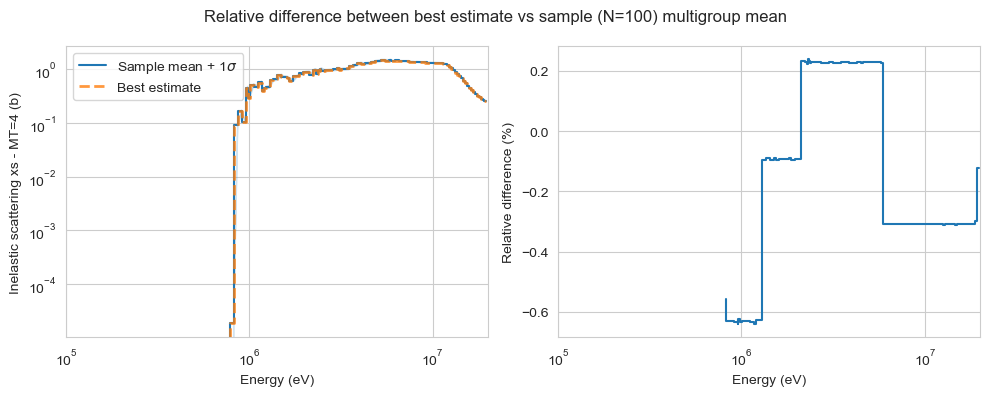

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

ax = axs[0]
sns.lineplot(data=multigroup_samples, x='E', y="XS", ci="sd", ax=ax, label='Sample mean + 1$\\sigma$', drawstyle='steps-pre')
stack_o.plot(x='E', y='XS process', ax=ax, alpha=0.8, style="--", linewidth=2, label="Best estimate", drawstyle='steps-pre')
ax.set_xlim([1e+5, 2e7])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(f'Inelastic scattering xs - MT={mt} (b)')
ax.set_xlabel('Energy (eV)')

ax = axs[1]
sns.lineplot(data=stack_o, x='E', y='relative diff', ax=ax, drawstyle='steps-pre')
ax.set_xscale('log')
ax.set_ylabel('Relative difference (%)')
ax.set_xlim([1e+5, 2e7])
ax.set_xlabel('Energy (eV)')
fig.suptitle(f'Relative difference between best estimate vs sample (N={NSMP}) multigroup mean')

fig.tight_layout()

Visual comparison of the correlation matrix: sample multigroup vs Errorr file

In [42]:
cov = sandy.CategoryCov(cov_original.data.loc[(mat, mt), (mat, mt)])
cov_samples = sandy.EnergyCov(df_groups.query(f"MT == {mt}").cov()).data
cov_samples.index, cov_samples.columns = cov_samples.index.left, cov_samples.columns.left
cov_samples = sandy.EnergyCov(cov_samples)

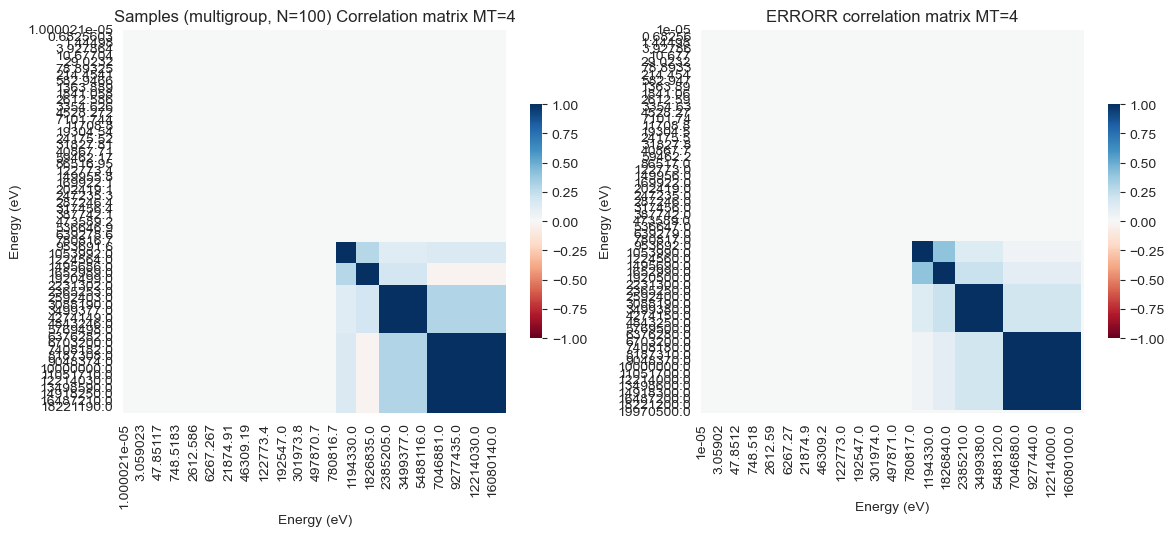

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 12), dpi=100)
ax1, ax2 = axes

# Formatting for heat map 1.
ax1.set_aspect("equal")
cov_samples.plot_corr(ax=ax1, cbar_kws={"shrink": .2})
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Energy (eV)')
ax1.set_title(f'Samples (multigroup, N={NSMP}) Correlation matrix MT={mt}')

ax2.set_aspect("equal")
cov.plot_corr(ax=ax2, cbar_kws={"shrink": .2})
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Energy (eV)')
ax2.set_title(f'ERRORR correlation matrix MT={mt}')

fig.tight_layout()

Standard deviation:

In [44]:
df_samples = df_groups.query(f"MT == {mt}").T.std(axis=1)/df_groups.query(f"MT == {mt}").T.mean(axis=1)*100
df_samples = pd.Series(df_samples.values, index=df_samples.index.left)
df_process = cov.std*100
df_std = (1-df_samples/df_process.drop(df_process.index[-1]).values)*100

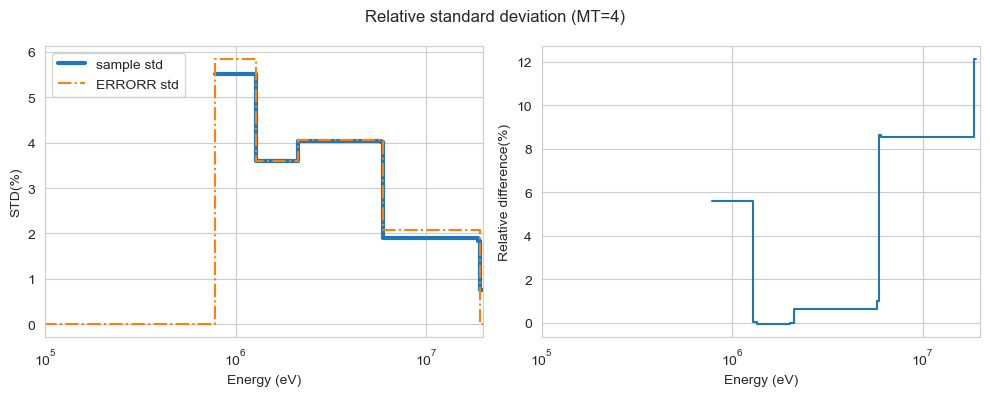

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

ax = axs[0]
df_samples.plot(logx=True, drawstyle='steps-pre', ax=ax, linewidth=3, label='sample std')
df_process.plot(logx=True, drawstyle='steps-pre', ax=ax, style="-.", label='ERRORR std')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('STD(%)')
ax.set_xlim([1e+5, 2e7])
ax.legend(loc='upper left')

ax = axs[1]
df_std.plot(logx=True, drawstyle='steps-pre', ax=ax)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Relative difference(%)')
ax.set_xlim([1e+5, 2e7])

fig.suptitle(f'Relative standard deviation (MT={mt})')
fig.tight_layout()

Sample distribution

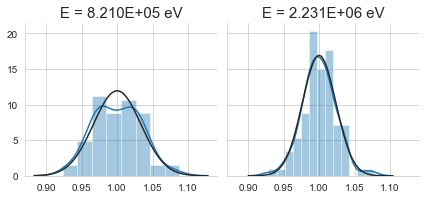

In [50]:
distribution = df_groups_small.query(f"MT == {mt}").stack().rename("XS").reset_index()
distribution['E'] = pd.Index(distribution['E']).left.values
Xs_calc = distribution.groupby('E')['XS'].mean().reindex(distribution['E'])
distribution = distribution.set_index('E')
distribution['Distribution'] = distribution['XS']/Xs_calc
distribution = distribution.reset_index().dropna()
g = sns.FacetGrid(distribution, col="E", col_wrap=3, height=3)
g.map(sns.distplot, "Distribution", fit=norm)
g.set_titles(col_template="E = {col_name:.3E} eV", fontsize=18, size=15) 
g.set_xlabels("")
g.set_ylabels("")

Best estimates of samples vs number of samples

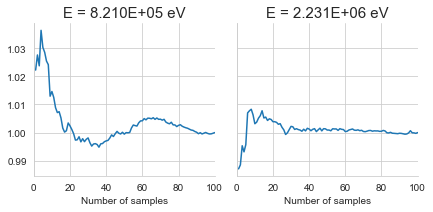

In [53]:
mean_sample = best_estimate_vs_samples_mean(df_groups_small.query(f"MT == {mt}")).dropna()
g = sns.FacetGrid(mean_sample, col="E", col_wrap=3, height=3, xlim=(0, NSMP))
g.map(sns.lineplot, "SMP", "sample mean")
g.set_titles(col_template="E = {col_name:.3E} eV", fontsize=18, size=15) 
g.set_xlabels("Number of samples")
g.set_ylabels("")

Standard deviation of samples vs number of samples

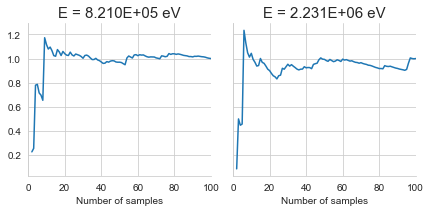

In [54]:
std_sample = std_vs_samples_mean(df_groups_small.query(f"MT == {mt}")).dropna()
g = sns.FacetGrid(std_sample, col="E", col_wrap=3, height=3, xlim=(0, NSMP))
g.map(sns.lineplot, "SMP", "sample std")
g.set_titles(col_template="E = {col_name:.3E} eV", fontsize=18, size=15) 
g.set_xlabels("Number of samples")
g.set_ylabels("")